# Load Models

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
import cv2
from PIL import Image

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tempfile

tmpdir = '/content/drive/MyDrive/Anime Colorization/'
model_save_path = os.path.join(tmpdir, "models/")
test_data_path = os.path.join(tmpdir, "inference test data/")
print(model_save_path)

/content/drive/MyDrive/Anime Colorization/models/


In [ ]:
models = {'Dragon Ball': None}
model_number = 25
for model_name in models.keys():
  # print(models_path, last_folder)
  models[model_name] = tf.keras.models.load_model(model_save_path + model_name + "/" + str(model_number))
  
print(models)

{'Dragon Ball': <keras.engine.functional.Functional object at 0x7f9349165050>}


Test on random noise

(1, 256, 256, 3)


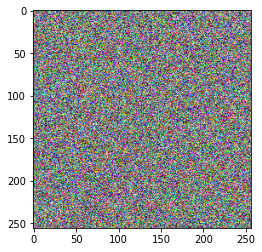

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


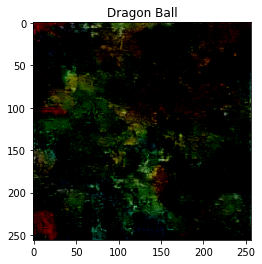

In [ ]:
rands = np.random.rand(256,256,3)
plt.imshow(rands)
tensor = tf.convert_to_tensor(rands)
tensor = tf.expand_dims(tensor,0)
print(tensor.shape)
plt.show()
for model_name, model in models.items():
  prediction = model(tensor, training=True)
  plt.title(model_name)
  plt.imshow(prediction[0])
  plt.show()

## Test on fan art

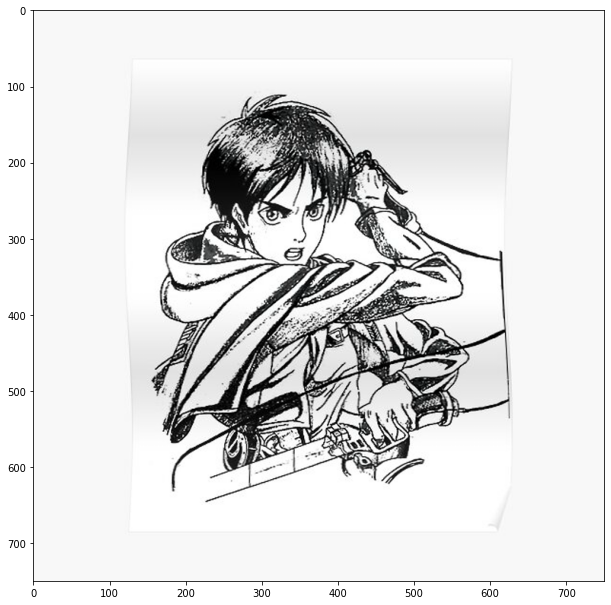

In [ ]:
image_path = os.path.join(test_data_path, "dragon_ball/fan_art_1.jpg")
image_path = os.path.join(test_data_path, "attack_on_titan/fan_art_1.jpg")
# print(test_data_path, image_path)
# sample_image = tf.io.read_file(image_path)
# sample_image = tf.io.decode_jpeg(sample_image)
img = cv2.imread(image_path)
# res = img
scale_down = 0.8
res = cv2.resize(img, dsize=(int(img.shape[1]/scale_down), int(img.shape[0]/scale_down)), interpolation=cv2.INTER_CUBIC)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(res)

In [ ]:
def run_prediction(model, pil_image):
  resized = pil_image

  if (resized.shape[0] < resized.shape[1]):
    # print(resized.shape, '1 is smaller')
    scale_down = resized.shape[0] / 256
    resized = cv2.resize(pil_image, dsize=(int(resized.shape[1]/scale_down), int(resized.shape[0]/scale_down)), interpolation=cv2.INTER_CUBIC)

    fromV  = int((res.shape[1] - 256) / 2)
    toV = fromV + 256
    resized = resized[:,fromV:toV]
  else:
    # print(resized.shape, '2 is smaller')
    scale_down = resized.shape[1] / 256
    resized = cv2.resize(pil_image, dsize=(int(resized.shape[1]/scale_down), int(resized.shape[0]/scale_down)), interpolation=cv2.INTER_CUBIC)
    # print('smaller', resized.shape)
    fromV  = int((resized.shape[0] - 256) / 2)
    toV = fromV + 256
    # print(fromV, toV)
    resized = resized[fromV:toV, :]
    # print('smaller', resized.shape)
  
  # Convert to array from [-1,1]
  arr = ((np.array(resized) / 127.5) - 1)

  # Predict
  prediction = model(np.array([arr]), training=True)
  
  # Adjust contrast
  # output = tf.image.adjust_contrast(prediction[0]*0.5 + 0.5, 1.3)
  # output = tf.image.adjust_contrast(prediction[0]*0.5 + 0.5, 1)
  output = prediction[0]*0.5 + 0.5
  # Back to 255 range
  result_array = np.clip(np.array(output)* 255,0,255).astype(dtype=np.uint8)

  # To Image
  img = Image.fromarray(result_array)
  return img

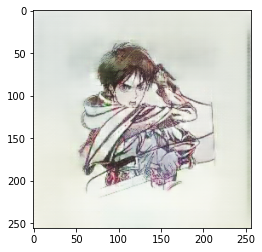

In [ ]:
img2 = run_prediction(models['Fruit Basket'], img)
plt.imshow(img2)

# Create and Run a Flask Endpoint

Intall library

In [ ]:
!pip install flask-ngrok

Uncomment the following and run once. Then comment back

In [ ]:
!curl -O https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.1M  100 13.1M    0     0  1049k      0  0:00:12  0:00:12 --:--:-- 2398k


In [ ]:
!tar -xf ngrok-stable-linux-amd64.tgz

In [ ]:
!./ngrok authtoken 25GApjJ4lupn0T0uB3skK1sJ2af_2u8xbVJUPARtgvbs9LRTq

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask import Flask, request, send_file
from flask_ngrok import run_with_ngrok
import base64
import io
from PIL import Image
from matplotlib import cm
import json

app = Flask(__name__)

@app.route("/")
def root():
  return 'Root of Flask WebApp!'

@app.route("/predict", methods=["POST"])
def process_image():
    file = request.files['image']
    # Read the image via file.stream
    img = Image.open(file.stream)
    img.save('temp.jpg')
    # open as array
    img_arr = cv2.imread('temp.jpg')
    # print(img.shape)
    predictions = {}
    for model_name, model in models.items():
      result_img = run_prediction(model, img_arr)
      result_img.save(model_name + '_pred.jpg', format="JPEG")

      with open(model_name + '_pred.jpg', "rb") as f:
        im_b64 = base64.b64encode(f.read())

      print(im_b64)
      # im_bytes = base64.b64decode(im_b64)   # im_bytes is a binary image
      # print(im_bytes)

      predictions[model_name] = im_b64.decode("utf-8") 

    print(predictions)
    return json.dumps({'msg': 'success', 'predictions': predictions})

run_with_ngrok(app)

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://d128-35-205-180-80.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [01/Apr/2022 21:56:42] "POST /predict HTTP/1.1" 200 -


b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDoQ23gAKB0xUwkJBOaohyB/CvXr0/Op0bP8Sn6GvDWx1stB2Dde2BUyu3eq7DHcVLNKsMQJK4I+lNEle5k2Zwf/rViX0rshZSS6cqo7itS7mjkhzG4Zscisd3l3Foxhhxnt9KTVnc1jqjNS9lyJo7hvMzyvP5VVmee43M52s

127.0.0.1 - - [01/Apr/2022 21:57:41] "POST /predict HTTP/1.1" 200 -


b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2ExKiLhVHHYUgA5xgcVK3IXgdKbjFYMwAcccYxUbABWIA6elSkY/Ko5Puke1IRlahKVCgEYxXO3c7jcRW5qZAQn0H+Nc7L+8JAwefWsZuzNIv3TRtAXCEuudvSrrgqnDqvYZqnZR7dmSBwa1AoIxuB/CmMIU24y4bjHGKdM

127.0.0.1 - - [01/Apr/2022 21:58:26] "POST /predict HTTP/1.1" 200 -


b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDuCWjICkqMcD0pDK3c9O3tUXmHA45x3NNLsfSvOnex3JaiuxPI49MVGS5x83GelKWPemFz/dFZJM0HgOe5p67gCOlMR8jtSndnPFDuA0qeo69qfHuJPtTS3yZwOtCybQcjPpg1N2JstqSAO3sKBMwJGajEnAyBmo2bk81aeh

127.0.0.1 - - [01/Apr/2022 21:59:06] "POST /predict HTTP/1.1" 200 -


b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0bGMDpj0oMm0YBobP0qJxTPPsO389ePY0pk68/rTFXjpSlP8AZpAAlOcZ/Wkac+tJs9qjdTjgUh6jXmOetIs2OT2pdnqMGomXBOGXP1qkhFuGcBtvSub8TeK4IYJLK0VHus4LkfLGPwPXnpUmu6qNNsnWMjz5VKpz06815s

127.0.0.1 - - [01/Apr/2022 22:05:54] "POST /predict HTTP/1.1" 200 -


b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDvPC8ynwzp2QmRAuMAegrcjlHPSuW8Hnd4Z07JxiADH4L0NdAp2seaxaWpzO6sXfMHQYxTQQT2H4VAH56ipA3vUhe5MrcY4xTS4zjjFNBHrTSRzyDSGTbsjtUZI9vypcgY5oOKYmKjDpxj6Uu8DgYx9KaAB3FNPfBFAE6keg